<a href="https://colab.research.google.com/github/daniel970213/segunda-parte-del-proyecto/blob/main/redes_neuronales_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# cargamos las librerias a utilizar

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
 
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
 


In [ ]:
# esta celda sirve para dar permiso al accedo de tus archivos del gdrive
link ='https://docs.google.com/spreadsheets/d/e/2PACX-1vTRmmsm3qKHPv04W2q5Vp57bVLa6tc706boLNhS7mVtH1hh4gpkAfRT7d1XsQYd1g/pub?gid=145097224&single=true&output=csv'

In [ ]:
df = pd.read_csv(link)
df.head()

,timestamp,demand
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [ ]:
df.timestamp = pd.to_datetime(df.timestamp,)

In [ ]:
# al mes lo ponemos como indice

df.set_index('timestamp',inplace=True,)
df.head()

,demand
timestamp,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [ ]:
# para ver el rango de fechas va de enero 2017 a noviembre 2018

print(df.index.min())
print(df.index.max())

1964-01-01 00:00:00
1972-09-01 00:00:00


In [ ]:
df.shape

(105, 1)

In [ ]:
# cantidad de registros por año

print(len(df['1964']))
print(len(df['1972']))

12
9


In [ ]:
# ver estadísticos básicos

df.describe()

,demand
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


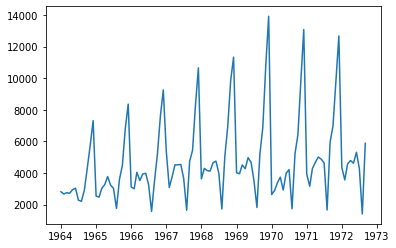

In [ ]:
plt.plot(df.index,df.demand)

In [ ]:
# cálculo de la media por mes

meses =df.resample('M').mean()
meses.head()

,demand
timestamp,
1964-01-31,2815
1964-02-29,2672
1964-03-31,2755
1964-04-30,2721
1964-05-31,2946


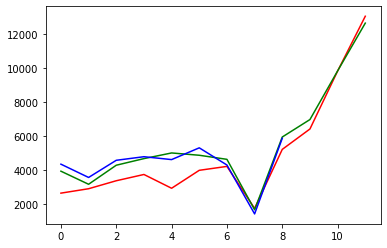

In [ ]:
# Comparando las ventas mensuales los años 1971 y 1972

plt.plot(meses['1970'].values,color='r')
plt.plot(meses['1971'].values,color='g')
plt.plot(meses['1972'].values,color='b')

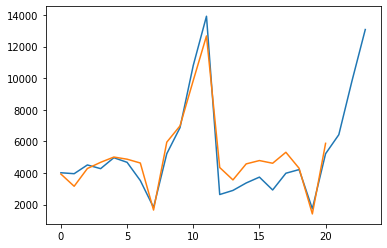

In [ ]:
# comparo 2 periodos de tiempo

verano1970 = df['1969-01-01':'1970-12-01']
plt.plot(verano1970.values)
verano1971 = df['1971-01-01':'1972-12-01']
plt.plot(verano1971.values)

In [ ]:
## iniciamos la NN

## PASOS es la cantidad de predictores 

PASOS=12

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
12,-0.775734,-0.798608,-0.785331,-0.790770,-0.754779,-0.740382,-0.860993,-0.872191,-0.758618,-0.538031,-0.304007,-0.056386,-0.819563
13,-0.798608,-0.785331,-0.790770,-0.754779,-0.740382,-0.860993,-0.872191,-0.758618,-0.538031,-0.304007,-0.056386,-0.819563,-0.830121
14,-0.785331,-0.790770,-0.754779,-0.740382,-0.860993,-0.872191,-0.758618,-0.538031,-0.304007,-0.056386,-0.819563,-0.830121,-0.741182
15,-0.790770,-0.754779,-0.740382,-0.860993,-0.872191,-0.758618,-0.538031,-0.304007,-0.056386,-0.819563,-0.830121,-0.741182,-0.703591
16,-0.754779,-0.740382,-0.860993,-0.872191,-0.758618,-0.538031,-0.304007,-0.056386,-0.819563,-0.830121,-0.741182,-0.703591,-0.622011


In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 105 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(63, 1, 12) (63,) (30, 1, 12) (30,)


In [ ]:
# Creando la red neuronal

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


In [ ]:
EPOCHS=100

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 12)             156       
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 14s 103ms/step - loss: 0.3256 - mse: 0.1463 - val_loss: 0.3436 - val_mse: 0.1778
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.2967 - mse: 0.1226 - val_loss: 0.3162 - val_mse: 0.1600
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 0.2576 - mse: 0.0987 - val_loss: 0.2959 - val_mse: 0.147

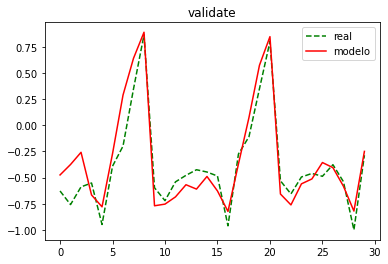

In [ ]:
results = model.predict(x_val)
plt.plot(range(len(y_val)),y_val,c='g',label='real',ls='--')
plt.plot(range(len(results)),results,c='r',label='modelo')
plt.title('validate')
plt.legend(loc='best')

In [ ]:
df.tail()

,demand
timestamp,
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298
1972-08-01,1413
1972-09-01,5877


In [ ]:
# con esta data calcularemos los próximos 7 datos futuros

ultimosDias = df['1970-10-01':'1972-09-01']
ultimosDias

,demand
timestamp,
1970-10-01,6424
1970-11-01,9842
1970-12-01,13076
1971-01-01,3934
1971-02-01,3162
1971-03-01,4286
1971-04-01,4676
1971-05-01,5010
1971-06-01,4874


In [ ]:
ultimosDias.shape

(24, 1)

In [ ]:
# elimino la columna 12 porque deseo predecirla

values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = values
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
reframed # modificar acorde al numero de predictores

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
12,6424.0,9842.0,13076.0,3934.0,3162.0,4286.0,4676.0,5010.0,4874.0,4633.0,1659.0,5951.0
13,9842.0,13076.0,3934.0,3162.0,4286.0,4676.0,5010.0,4874.0,4633.0,1659.0,5951.0,6981.0
14,13076.0,3934.0,3162.0,4286.0,4676.0,5010.0,4874.0,4633.0,1659.0,5951.0,6981.0,9851.0
15,3934.0,3162.0,4286.0,4676.0,5010.0,4874.0,4633.0,1659.0,5951.0,6981.0,9851.0,12670.0
16,3162.0,4286.0,4676.0,5010.0,4874.0,4633.0,1659.0,5951.0,6981.0,9851.0,12670.0,4348.0
17,4286.0,4676.0,5010.0,4874.0,4633.0,1659.0,5951.0,6981.0,9851.0,12670.0,4348.0,3564.0
18,4676.0,5010.0,4874.0,4633.0,1659.0,5951.0,6981.0,9851.0,12670.0,4348.0,3564.0,4577.0
19,5010.0,4874.0,4633.0,1659.0,5951.0,6981.0,9851.0,12670.0,4348.0,3564.0,4577.0,4788.0
20,4874.0,4633.0,1659.0,5951.0,6981.0,9851.0,12670.0,4348.0,3564.0,4577.0,4788.0,4618.0
21,4633.0,1659.0,5951.0,6981.0,9851.0,12670.0,4348.0,3564.0,4577.0,4788.0,4618.0,5312.0


In [ ]:
# elimino la columna 12 porque deseo predecirla

values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
reframed.head(12) # modificar acorde al numero de predictores

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
12,-0.140701,0.445426,1.000000,-0.567693,-0.700077,-0.507331,-0.440453,-0.383178,-0.406499,-0.447826,-0.957815,-0.221813
13,0.445426,1.000000,-0.567693,-0.700077,-0.507331,-0.440453,-0.383178,-0.406499,-0.447826,-0.957815,-0.221813,-0.045186
14,1.000000,-0.567693,-0.700077,-0.507331,-0.440453,-0.383178,-0.406499,-0.447826,-0.957815,-0.221813,-0.045186,0.446969
15,-0.567693,-0.700077,-0.507331,-0.440453,-0.383178,-0.406499,-0.447826,-0.957815,-0.221813,-0.045186,0.446969,0.930378
16,-0.700077,-0.507331,-0.440453,-0.383178,-0.406499,-0.447826,-0.957815,-0.221813,-0.045186,0.446969,0.930378,-0.496699
17,-0.507331,-0.440453,-0.383178,-0.406499,-0.447826,-0.957815,-0.221813,-0.045186,0.446969,0.930378,-0.496699,-0.631141
18,-0.440453,-0.383178,-0.406499,-0.447826,-0.957815,-0.221813,-0.045186,0.446969,0.930378,-0.496699,-0.631141,-0.457429
19,-0.383178,-0.406499,-0.447826,-0.957815,-0.221813,-0.045186,0.446969,0.930378,-0.496699,-0.631141,-0.457429,-0.421247
20,-0.406499,-0.447826,-0.957815,-0.221813,-0.045186,0.446969,0.930378,-0.496699,-0.631141,-0.457429,-0.421247,-0.450399
21,-0.447826,-0.957815,-0.221813,-0.045186,0.446969,0.930378,-0.496699,-0.631141,-0.457429,-0.421247,-0.450399,-0.331390


In [ ]:
# con la fila "x" modificar la fila

values = reframed.values
x_test = values[11:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[-0.2218126 , -0.04518557,  0.44696903,  0.9303781 ,
         -0.49669892, -0.6311412 , -0.45742947, -0.42124665,
         -0.45039868, -0.33138984, -0.50527304, -1.        ]]],
      dtype=float32)

In [ ]:
# con esto lleno la matriz para seguir calculando los días 2 de diciembre en adelante con los 12 previos

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

results=[]
for i in range(24):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.2218126  -0.04518557  0.44696903  0.9303781  -0.49669892
   -0.6311412  -0.45742947 -0.42124665 -0.45039868 -0.33138984
   -0.50527304 -1.        ]]]
[[[-0.04518557  0.44696903  0.9303781  -0.49669892 -0.6311412
   -0.45742947 -0.42124665 -0.45039868 -0.33138984 -0.50527304
   -1.         -0.19367954]]]
[[[ 0.44696903  0.9303781  -0.49669892 -0.6311412  -0.45742947
   -0.42124665 -0.45039868 -0.33138984 -0.50527304 -1.
   -0.19367954  0.2776371 ]]]
[[[ 0.9303781  -0.49669892 -0.6311412  -0.45742947 -0.42124665
   -0.45039868 -0.33138984 -0.50527304 -1.         -0.19367954
    0.2776371   0.64454716]]]
[[[-0.49669892 -0.6311412  -0.45742947 -0.42124665 -0.45039868
   -0.33138984 -0.50527304 -1.         -0.19367954  0.2776371
    0.64454716  0.87142396]]]
[[[-0.6311412  -0.45742947 -0.42124665 -0.45039868 -0.33138984
   -0.50527304 -1.         -0.19367954  0.2776371   0.64454716
    0.87142396 -0.61674887]]]
[[[-0.45742947 -0.42124665 -0.45039868 -0.33138984 -0.50527304
   -1.     

In [ ]:
# invierto los valores pronosticados para que se entienda original valores escalados

adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[ 6115.0576818 ],
       [ 8863.54071868],
       [11003.17685237],
       [12326.20892085],
       [ 3647.92882664],
       [ 2859.63847309],
       [ 4385.96176418],
       [ 4817.39563186],
       [ 5049.64359741],
       [ 5310.44858376],
       [ 3645.43212721],
       [ 2445.37719121],
       [ 6355.88073066],
       [11039.6464604 ],
       [11715.59854771],
       [12134.17613386],
       [ 2876.88804886],
       [ 2412.72232301],
       [ 4210.31115584],
       [ 5147.2788657 ],
       [ 5313.72317729],
       [ 5472.17252411],
       [ 3167.05853752],
       [ 3020.50857212]])

In [ ]:
# concatenar df

df.head()

,demand
timestamp,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [ ]:
y_pred=pd.DataFrame(inverted)
len(y_pred)

24

In [ ]:
y_pred.tail()

,0
19,5147.278866
20,5313.723177
21,5472.172524
22,3167.058538
23,3020.508572


In [ ]:
df2=pd.concat([df,y_pred])

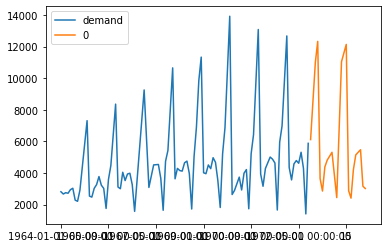

In [ ]:
df2.plot()

In [ ]:
df2.columns

Index(['sales', 0], dtype='object')

In [ ]:
df2.head()

,sales,0
1964-01-01 00:00:00,2815.0,NaN
1964-02-01 00:00:00,2672.0,NaN
1964-03-01 00:00:00,2755.0,NaN
1964-04-01 00:00:00,2721.0,NaN
1964-05-01 00:00:00,2946.0,NaN
